In [1]:
%load_ext autoreload
%autoreload 2

here the objective is to fit the LG fitted simulation to a PCA/UMAP to check the viz

In [2]:
import sys
import os
sys.path.append('../')

#Graph imports
import src.graph as graph
import src.logit_estimator as estimator
import src.utils as utils
import src.model_selection as model_selection
import src.gic as gic
import src.param_estimator as pe
import src.graph as graph
import src.model_selection as ms

# usual imports
import matplotlib.pyplot as plt
import pickle
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx
from numpy import errstate

from IPython.display import display
from pyvis.network import Network
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
PATH = f'../data/connectomes/brain_graph/'
DATASET = f'repeated_10_scale_60'

files = sorted(os.listdir(PATH+DATASET))

In [4]:
len(files)

1064

In [ ]:
# Read the first 10 graphml files
graphs = [nx.read_graphml(PATH+DATASET+'/'+file) for file in files[:30]]

# Create a list of graphs
graphs = [nx.read_graphml(PATH+DATASET+'/'+file) for file in files[:30]]

In [ ]:
def visualize_first_n_graphs(graphs, n=10, figsize=(15, 10), node_size=300, font_size=8, edge_width=0.5):
    """
    Visualize the first n graphs in a publication-ready format.
    
    Parameters:
    -----------
    graphs : list
        List of NetworkX graphs
    n : int
        Number of graphs to visualize
    figsize : tuple
        Figure size (width, height)
    node_size : int
        Size of nodes in the visualization
    font_size : int
        Font size for node labels
    edge_width : float
        Width of edges
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure
    """
    # Limit n to available graphs
    n = min(n, len(graphs))
    
    # Calculate grid dimensions
    cols = min(4, n)  # Maximum 4 columns
    rows = (n + cols - 1) // cols  # Ceiling division
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    # Handle single subplot case
    if n == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes if hasattr(axes, '__iter__') else [axes]
    else:
        axes = axes.flatten()
    
    # Color scheme for publication quality
    node_color = '#4472C4'  # Professional blue
    edge_color = '#8B8B8B'  # Subtle gray
    
    for i in range(n):
        G = graphs[i]
        ax = axes[i]
        
        # Use spring layout for consistent positioning
        pos = nx.spring_layout(G, k=1, iterations=50, seed=42)
        
        # Draw edges first (so they appear behind nodes)
        nx.draw_networkx_edges(G, pos, ax=ax, 
                              edge_color=edge_color, 
                              width=edge_width, 
                              alpha=0.6)
        
        # Draw nodes
        nx.draw_networkx_nodes(G, pos, ax=ax,
                              node_color=node_color,
                              node_size=node_size,
                              alpha=0.8)
        
        # Set title and remove axes
        ax.set_title(f'Graph {i+1}\n({G.number_of_nodes()} nodes, {G.number_of_edges()} edges)',
                    fontsize=font_size+2, fontweight='bold', pad=10)
        ax.axis('off')
    
    # Hide unused subplots
    for i in range(n, len(axes)):
        axes[i].axis('off')
    
    # Adjust layout for publication quality
    plt.tight_layout(pad=2.0)
    
    # Add overall title
    #fig.suptitle(f'Brain Connectome Graphs (First {n} samples)\n\n', 
    #            fontsize=16, fontweight='bold', y=0.98)
    
    return fig


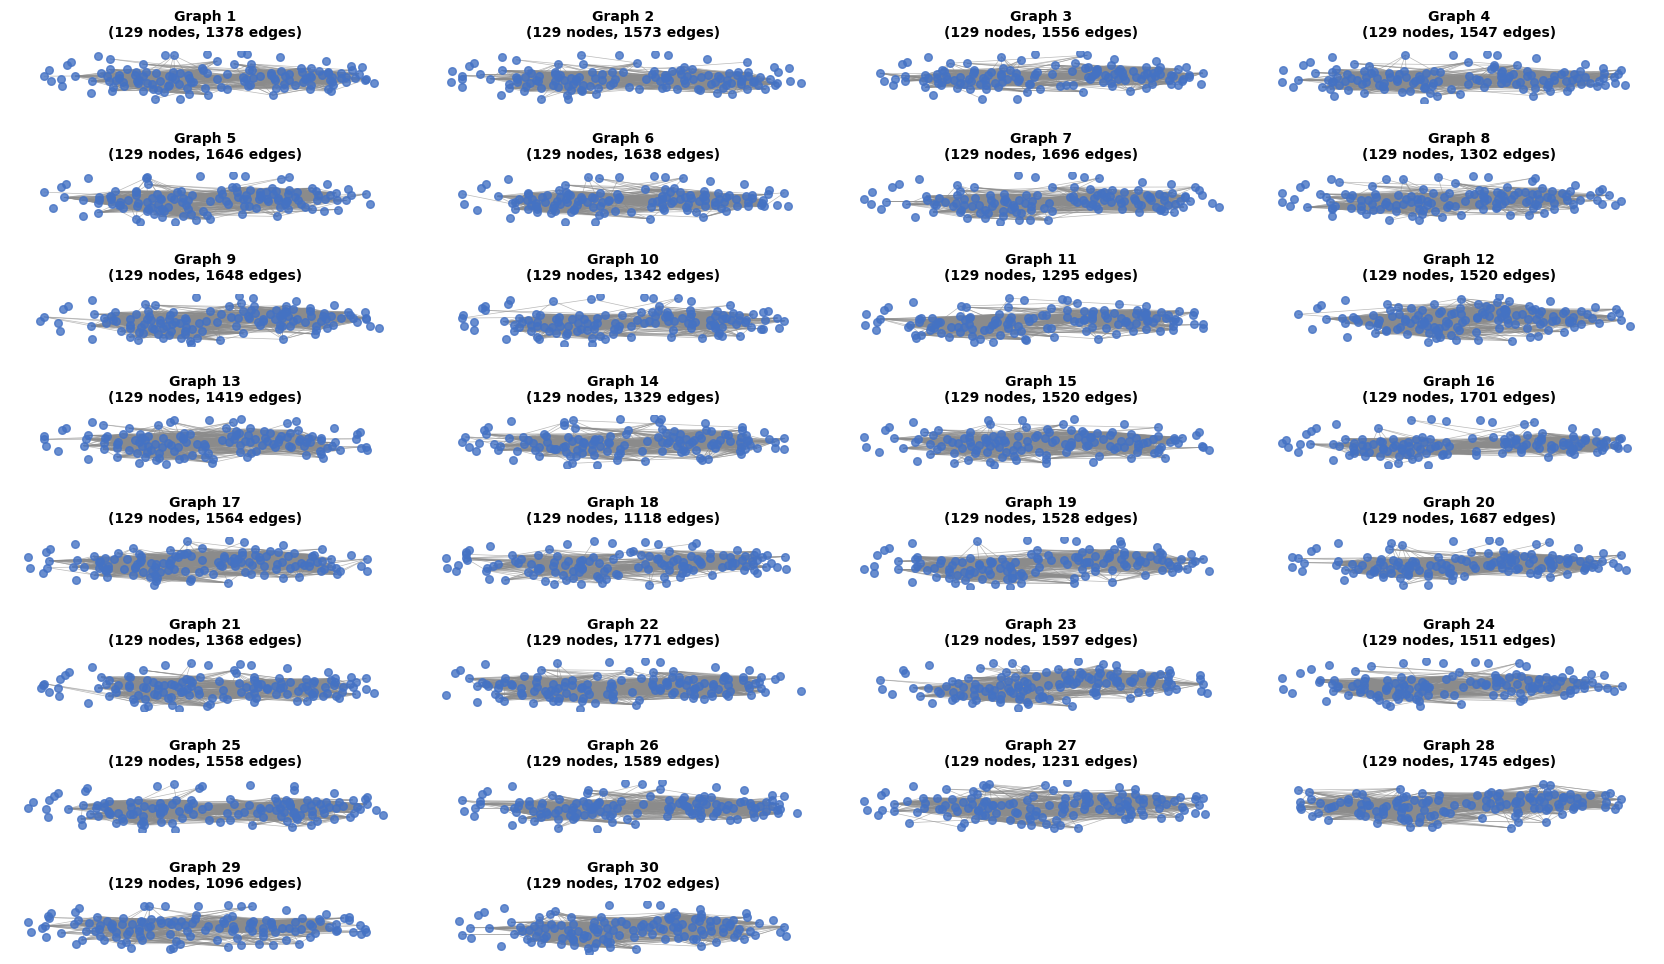

In [ ]:
fig = visualize_first_n_graphs(graphs, n=30, figsize=(17, 10), node_size=30, font_size=8, edge_width=0.5)